### Comments regarding GP and response 2010 
source data data.gov.uk

The purpose of this notebook is to provide a mini prototype of sentiment analysis applications, aiming to extract insights from NHS Choices GP comment and response from 2010, downloaded from http://data.gov.uk 

In [ ]:
# load libraries for data prep

import pandas as pd
import numpy as np

nhs = pd.read_excel(open('gp-comments-and-responses.xls', 'rb'), skiprows=6)
#nhs.head()

Since this is a text mining application, we are to include only free text columns to analyse

In [ ]:
# Tidy data - get rid of space in column names
nhs.columns = [c.replace(' ', '') for c in nhs.columns] 

# data profile
nhs.info()

# how many response by hospital
print(nhs.OrganisationName.value_counts())

In [ ]:
# Select 3
nhs = nhs[['OrganisationName', 'Liked', 'Disliked','CommentTitle']]

In [ ]:
# Start with analysing Comment Titles

titles = nhs[["CommentTitle"]].dropna()
titles

### Sentiment Analysis using API (MonkeyLearn)


In [ ]:
# out of the box example

from monkeylearn import MonkeyLearn
 
ml = MonkeyLearn('my API')
data = ['The restaurant was great!', 'The curtains were disgusting']
model_id = 'cl_pi3C7JiL'
result = ml.classifiers.classify(model_id, data)
 
print(result.body)

In [ ]:
'''
Now we can use monkey learn API for our dataset

'''

# free, limited to 300 calls a month
# Python has index 0, so here I choose 1st rows up to row 10, exclude row 10.
# MonkeyLearn takes list as an argument so I change dataframe to list

titles_samples = titles[0:3:]
title_samples = titles_samples['CommentTitle'].tolist()

result = []
r = ml.classifiers.classify(model_id, title_samples)
result.append(r)
r
result

In [50]:
r.body

[{'text': 'The approach of doctors and staff gives confidence',
  'external_id': None,
  'error': False,
  'classifications': [{'tag_name': 'Positive',
    'tag_id': 122921383,
    'confidence': 0.774}]},
 {'text': 'Less Work, More queue',
  'external_id': None,
  'error': False,
  'classifications': [{'tag_name': 'Negative',
    'tag_id': 122921385,
    'confidence': 0.467}]},
 {'text': 'Rudeness',
  'external_id': None,
  'error': False,
  'classifications': [{'tag_name': 'Negative',
    'tag_id': 122921385,
    'confidence': 0.522}]}]

### Sentiment Analysis - textblob libary
We will start with Comment Title column.


In [51]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

# an example out of the box

blob = TextBlob("I love this library", analyzer=NaiveBayesAnalyzer())
blob.sentiment


Sentiment(classification='pos', p_pos=0.7996209910191279, p_neg=0.2003790089808724)

In [52]:
## only pick first 100 to explore for performance

titles = titles[:10:]

In [53]:
%%time
sentiment_comment = list()

for i in titles['CommentTitle'].tolist():
    
    blob = TextBlob(i, analyzer=NaiveBayesAnalyzer())
    blob.sentiment
    sentiment_comment.append((i,blob.sentiment.classification, blob.sentiment.p_pos, blob.sentiment.p_neg))

sentiment_comment

Wall time: 48.2 s


[('The approach of doctors and staff gives confidence',
  'pos',
  0.7935835289882488,
  0.20641647101175187),
 ('Less Work, More queue', 'pos', 0.7950752726256483, 0.204924727374351),
 ('Rudeness', 'pos', 0.5, 0.5),
 ('Complacent GP, Misdiagnoses abound',
  'pos',
  0.7203389830508482,
  0.27966101694915246),
 ('without compassion on the phone.',
  'pos',
  0.6390607944852714,
  0.3609392055147289),
 ('Poor Service', 'neg', 0.3289713937918438, 0.6710286062081554),
 ('Best Doctors Ever', 'pos', 0.524174433238763, 0.4758255667612374),
 ('Poor service', 'neg', 0.3289713937918438, 0.6710286062081554),
 ('Some of the Doctors appear to be bored and disinterested sadly',
  'neg',
  0.024356708686459252,
  0.9756432913135415),
 ('Not great', 'pos', 0.59471387935229, 0.40528612064770997)]

Since a Naive Bayes text classifier is based on the Bayes’s Theorem, which helps us compute the conditional probabilities of occurrence of two events based on the probabilities of occurrence of each individual event, encoding those probabilities is extremely useful [1] 

1 minute to run sentiment analysis for 10 rows is quite slow. I will need to explore further for most optimal performance solution. 


### Text Mining - spaCy library approach

Preprocessing text is traditionally an important step for natural language processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better [3]

https://spacy.io/

The following are most common approach to preprocessing text

1. Clean up irregularities
2. Make it all lowercase
3. Remove punct , special character e.g @
4. Remove unhelpful terms, reduce size of data <- could be problematic in some context - we can customise stop words


In [ ]:
import spacy

# load spaCy pre-trained data model, I opt for small model, however you download medium (en_core_web_md) 
# and/or large model (en_core_web_lg)

nlp = spacy.load("en_core_web_sm")


Following are functions using ``re`` package

In [ ]:
import re #deal with regular expression

# Useful functions

def remove_special_char(text):
    text = re.sub('[^A-Za-z0-9]+'," ",text)
    return text

def remove_wordswithnum(text):
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

def lowercase(text):
    text = text.lower()
    return text

def remove_punctuations(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)



In [56]:
# We can run all preprocessing functions above, here I chose to switch the column to lowercase

for i in range(10):
    LikedComments['Liked'][i] = lowercase(titles['CommentTitle'][i])

LikedComments

,Liked
0,the approach of doctors and staff gives confid...
2,I had tried to register at this surgery as my ...
3,"Clean, smart surgery, polite and friendly rece..."
5,It's been a year since I have been with this ...
6,I have lived in many parts of the Country and ...
...,...
1946,"Unable to get an appointment for over 1 week, ..."
1947,"The doctor is the best GP in the practice, exc..."
1948,"The doctor is the best GP in the practice, exc..."
1950,My appointment was for 4.00pm and I arrived 5 ...


#### spaCy has doc object that comes with many processing pipeline as per figure below
![alt text](download.png "spaCy doc")
###### figure from spacy.io

In [57]:
# Here I import displacy to visualise named entity recognition from the pre-trained model 
from spacy import displacy


In [62]:
# below are the first 5 free text recorded in Liked column

for d in range(5):
    doc1 = LikedComments.iloc[d].apply(lambda x: nlp(x))
    displacy.render(doc1, style = "ent",jupyter = True)

C:\Users\nhaswell\AppData\Local\Continuum\anaconda3\lib\runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


C:\Users\nhaswell\AppData\Local\Continuum\anaconda3\lib\runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


C:\Users\nhaswell\AppData\Local\Continuum\anaconda3\lib\runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


According to Digital methods to enhance the usefulness of patient experience data in services for long-term conditions: the DEPEND mixed-methods study published in July 2020, it is indicated in Workstream 2: text mining, analysis and presentation of data that Theme distribution in the final data set will include:
- Staff attitude
- Care quality
- Waiting time
- Environment
- Other

https://www.journalslibrary.nihr.ac.uk/hsdr/hsdr08280#/abstract


Supposed that int this scenario, we have a group of key words that describe "staff attitude" such as
GP
Nurse
Staff

spaCy has "Matcher" function that allows us to extend built in vocabulary


In [75]:
from spacy.matcher import Matcher
# Match sequences of tokens, based on pattern rules

matcher = Matcher(nlp.vocab)

# identify sequence of tokens for rules

pattern = [{"LOWER": "doctors"}]

# suppose we call this rule 'Staff'

matcher.add("Staff", None, pattern)


text = "Going into hospital is a daunting experience but my stay at AGPH was remarkable.  The doctors and nurses were extremely kind, patient and caring.  Nothing was too much trouble, even in the middle of the night.  What stood out to me was the way they all went about their duties with a caring and kind attitude and a smile on their faces.  The catering staff were very kind and again nothing was too much trouble.  AGPH is set in beautiful surroundings in the Ribble Valley and as soon as you enter the building there is a sense of peace and calm.  I was quite nervous when I first went in but my fears were soon allayed.  I would have no hesitation in recommending this hospital and if I ever need surgery again it would be my first choice."

doc = nlp(text)

matches = matcher(doc)

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)


3046569444324441844 Staff 17 18 doctors


Match sequences of tokens, based on documents

In [79]:
from spacy.matcher import PhraseMatcher

matcher = PhraseMatcher(nlp.vocab)
matcher.add("Staff", None, nlp("doctors and nurses"))

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)


3046569444324441844 Staff 17 20 doctors and nurses


#### Note:
Observed there are many occurence of STOP_WORDS [2], this can be removed so we are left with meaningful words that we can analyse.

In [85]:
# Remove stop words
# Load Stop words [2]
from spacy.lang.en.stop_words import STOP_WORDS
import collections
STOP_WORDS
filtered = []

    
for word in LikedComments['Liked']:
    if word not in STOP_WORDS:
        filtered.append(word)

word_freq = collections.Counter(filtered)
print(collections.Counter(filtered))

Counter({'Nothing': 28, 'Nothing.': 10, 'not much': 3, 'poor service': 2, 'First class service': 2, 'Not much.': 2, 'Nothing!': 2, 'Very little.': 2, 'Facilities Are Modern and Clean. Consultation rooms are Nice.\n\nNurses Are All Lovely.': 2, 'Nothing!!!': 2, 'Normally ok to get an appointment if you can visit during the day - not very easy to get a later appointment though': 2, 'The doctor is the best GP in the practice, excellent, caring attitude.': 2, 'the approach of doctors and staff gives confidence': 1, 'rudeness': 1, 'complacent gp, misdiagnoses abound': 1, 'best doctors ever': 1, 'some of the doctors appear to be bored and disinterested sadly': 1, 'not great': 1, 'Very professional medical and nursing staff (when we get to see them)': 1, 'the staff are personable to the point of being almost familiar, but seem to have their "favourites...all of my other comments are relevant to this year...previously the practice was exemplary': 1, 'Nothing - maybe that it is walking distance

#### Note:
Expected words such as 'gp' and 'practice' appear as most common words, we may include these in the STOP WORDS.


In [86]:
# we can add our own stop words

STOP_WORDS.add("gp")
STOP_WORDS.add("practice")


for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
    
nlp.vocab['gp'].is_stop 
nlp.vocab['practice'].is_stop 

# Vice versa, we can remove them from the STOP WORDS list
STOP_WORDS.remove("gp")
STOP_WORDS.remove("practice")

There are some response that aren't meaningful / trivial which can be excluded from the analysis such as Nothing, not much, etc...

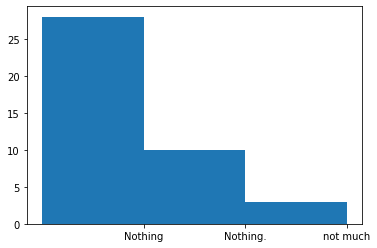

In [102]:
import matplotlib.pyplot as plt

t = {x: count for x, count in collections.Counter(filtered).items() if count > 2}

labels, values = zip(*collections.Counter(t).items())
indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Reference


1. Since a Naive Bayes text classifier is based on the Bayes’s Theorem, which helps us compute the conditional probabilities of occurrence of two events based on the probabilities of occurrence of each individual event, encoding those probabilities is extremely useful.
2. STOP WORDS - These are words that are important to complete the sentences but may amplify meaning in the sentences. These are in english grammar known as article, proposition, pronounce etc..
3. https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79#:~:text=Text%20preprocessing%20is%20traditionally,learning%20algorithms%20can%20perform%20better.
4. https://www.journalslibrary.nihr.ac.uk/hsdr/hsdr08280#/full-report
5. https://www.researchgate.net/publication/292943899_Enhancement_Bag-of-Words_Model_for_Solving_the_Challenges_of_Sentiment_Analysis
